In [ ]:
!pip install casadi
!pip install do-mpc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.9/162.9 kB 3.4 MB/s eta 0:00:00


In [ ]:
import sys
import os
import time

rel_do_mpc_path = os.path.join('..','..')
sys.path.append(rel_do_mpc_path)

import do_mpc
from do_mpc.data import save_results, load_results
from matplotlib.animation import FuncAnimation, PillowWriter

import time
import numpy as np

from casadi import *
from casadi.tools import *

/usr/local/lib/python3.12/dist-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/usr/local/lib/python3.12/dist-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


PARAMETRES UTILISATEUR

In [ ]:
theta_obj = np.pi/2 # Définition de l'angle objectif
#theta_p = np.pi # Définition de l'angle de point
gamma = np.pi # Définition du gamma
T = 50 # Définition de l'horizon d'optimisation
delta = 0.05 # Définition du pas d'échantillonnage

N_sim = 200 # Nombre de pas de temps de simulation

## DEFINITION DE L'OBSTACLE

obstacle = {'x': 0., 'y': 0, 'r': 0.4} # Cercle de centre (0,0) et de rayon 0.4m

# Definition cercle bleu
cercle_bleu = {'x': obstacle['x'], 'y': obstacle['y'], 'r': 0.6} # Défini le cercle sur lequel va devoir se positionner le robot

J = 2 #2 # Choix du critère

d_secu0 = 0.4+obstacle['r']  # Distance minimale de sécurité 0
d_secu1 = 0.3+obstacle['r']  # Distance minimale de sécurité 1
d_secu2 = 0.1+obstacle['r']  # Distance minimale de sécurité 2
d_secuf = 0.15+obstacle['r']  # Distance minimale de sécurité f

MODELISATION

In [ ]:
# Paramètres physiques:
l1 = 0.4 #m
l2 = 0.4 #m
l3 = 0.3 #m

# Creation du modele
model_type = "continuous"
model = do_mpc.model.Model(model_type)

# Variables d'état
x1 = model.set_variable(var_type='_x', var_name='x1', shape=(1,1))
x2 = model.set_variable(var_type='_x', var_name='x2', shape=(1,1))
x3 = model.set_variable(var_type='_x', var_name='x3', shape=(1,1))
x4 = model.set_variable(var_type='_x', var_name='x4', shape=(1,1))
x5 = model.set_variable(var_type='_x', var_name='x5', shape=(1,1))

# Variables de commande système
u1 = model.set_variable(var_type='_u', var_name='u1', shape=(1,1))
u2 = model.set_variable(var_type='_u', var_name='u2', shape=(1,1))
u3 = model.set_variable(var_type='_u', var_name='u3', shape=(1,1))
u4 = model.set_variable(var_type='_u', var_name='u4', shape=(1,1))

v1 = model.set_variable(var_type='_x', var_name='v1', shape=(1,1))
v2 = model.set_variable(var_type='_x', var_name='v2', shape=(1,1))
v3 = model.set_variable(var_type='_x', var_name='v3', shape=(1,1))
v4 = model.set_variable(var_type='_x', var_name='v4', shape=(1,1))

# Modèle dynamique du robot
model.set_rhs('x1', v1*np.cos(x3))
model.set_rhs('x2', v1*np.sin(x3))
model.set_rhs('x3', v2)
model.set_rhs('x4', v3)
model.set_rhs('x5', v4)

model.set_rhs('v1', u1)
model.set_rhs('v2', u2)
model.set_rhs('v3', u3)
model.set_rhs('v4', u4)

# Definition de la position du robot
p_x = model.set_expression('p_x', x1 + l1*np.cos(x3) + l2*np.cos(x3 + x4) + l3*np.cos(x3 + x4 + x5))
p_y = model.set_expression('p_y', x2 + l1*np.sin(x3) + l2*np.sin(x3 + x4) + l3*np.sin(x3 + x4 + x5))
theta = model.set_expression('theta', x3 + x4 + x5)

# Definiton des "paramètres à temps variant"

theta_set = model.set_variable('_tvp', 'theta_set')
#theta_point = model.set_variable('_tvp', 'theta_point')
p_x_set = model.set_expression('p_x_set', -cercle_bleu['r']*np.cos(theta_set))
p_y_set = model.set_expression('p_y_set', -cercle_bleu['r']*np.sin(theta_set))

p0_x_var = model.set_expression('p0_x_var', model.x['x1'])
p0_y_var = model.set_expression('p0_y_var', model.x['x2'])
p1_x_var = model.set_expression('p1_x_var', p0_x_var+l1*np.cos(model.x['x3']))
p1_y_var = model.set_expression('p1_y_var', p0_y_var+l1*np.sin(model.x['x3']))
p2_x_var = model.set_expression('p2_x_var', p0_x_var+l1*np.cos(model.x['x3']) + l2*cos(model.x['x3'] + model.x['x4']))
p2_y_var = model.set_expression('p2_y_var', p0_y_var+l1*np.sin(model.x['x3']) + l2*sin(model.x['x3'] + model.x['x4']))
pf_x_var = model.set_expression('pf_x_var', p0_x_var+l1*np.cos(model.x['x3']) + l2*cos(model.x['x3'] + model.x['x4']) + l3*cos(model.x['x3'] + model.x['x4'] + model.x['x5']))
pf_y_var = model.set_expression('pf_y_var', p0_y_var+l1*np.sin(model.x['x3']) + l2*sin(model.x['x3'] + model.x['x4']) + l3*sin(model.x['x3'] + model.x['x4'] + model.x['x5']))

# Definition des contraintes de non-collision
p0_x = model.x['x1']
p0_y = model.x['x2']
p1_x = p0_x+l1*np.cos(model.x['x3'])
p1_y = p0_y+l1*np.sin(model.x['x3'])
p2_x = p0_x+l1*np.cos(model.x['x3']) + l2*cos(model.x['x3'] + model.x['x4'])
p2_y = p0_y+l1*np.sin(model.x['x3']) + l2*sin(model.x['x3'] + model.x['x4'])
pf_x = p0_x+l1*np.cos(model.x['x3']) + l2*cos(model.x['x3'] + model.x['x4']) + l3*cos(model.x['x3'] + model.x['x4'] + model.x['x5'])
pf_y = p0_y+l1*np.sin(model.x['x3']) + l2*sin(model.x['x3'] + model.x['x4']) + l3*sin(model.x['x3'] + model.x['x4'] + model.x['x5'])

d0 = np.sqrt( (p0_x-obstacle['x'])**2 + (p0_y-obstacle['y'])**2 ) - obstacle['r']
d1 = np.sqrt( (p1_x-obstacle['x'])**2 + (p1_y-obstacle['y'])**2 ) - obstacle['r']
d2 = np.sqrt( (p2_x-obstacle['x'])**2 + (p2_y-obstacle['y'])**2 ) - obstacle['r']
df = np.sqrt( (pf_x-obstacle['x'])**2 + (pf_y-obstacle['y'])**2 ) - obstacle['r']

obstacle_distance = [d0, d1, d2, df]

obstacle_distance = model.set_expression('obstacle_distance', vertcat(*obstacle_distance))

# Mise en place du modèle
model.setup()

CONFIGURATION DE L'OPTIMISEUR

In [ ]:
# Creation de l'optimiseur
mpc = do_mpc.controller.MPC(model)

# Paramètres d'optimisation
setup_mpc = {
    'n_horizon': T,
    't_step': delta,
    'n_robust': 0,
    'store_full_solution': True,
}
mpc.set_param(**setup_mpc)

# Critères d'optimisation
err_posx = model.aux['p_x'] - model.aux['p_x_set']
err_posy = model.aux['p_y'] - model.aux['p_y_set']
err_angle = model.aux['theta'] - model.tvp['theta_set']

J1 = err_posx**2 + err_posy**2 + err_angle**2
J2 = err_posx**2 + err_posy**2 + err_angle**2 + v3**2 + v4**2

if J == 1:
    mterm = J1
    lterm = J1
else:
    mterm = J2
    lterm = J2

# Mise en place des critères d'optimisation
mpc.set_objective(mterm=mterm, lterm=lterm)

# Penalisation des variation de l'entree
mpc.set_rterm(
    u1=0.1,
    u2=0.1,
    u3=0.1,
    u4=0.1
)

# Definition de la variation de la position de l'effecteur
tvp_template_optim = mpc.get_tvp_template()
def pos_effecteur(t_ind):
    tvp_template_optim['_tvp',:, 'theta_set'] = theta_obj
    #tvp_template_optim['_tvp',:, 'theta_point'] = theta_p
    return tvp_template_optim

mpc.set_tvp_fun(pos_effecteur)

# Mise en place des contraintes

# Limites sur les positions
mpc.bounds['lower','_x','x1'] = -10
mpc.bounds['upper','_x','x1'] = 10
mpc.bounds['lower','_x','x2'] = -10
mpc.bounds['upper','_x','x2'] = 10

# Contraintes articulaires
mpc.bounds['lower','_x','x4'] = -gamma
mpc.bounds['upper','_x','x4'] = gamma
mpc.bounds['lower','_x','x5'] = -gamma
mpc.bounds['upper','_x','x5'] = gamma

# Limites sur la vitesse
mpc.bounds['lower','_x','v1'] = -1.5
mpc.bounds['upper','_x','v1'] = 1.5
mpc.bounds['lower','_x','v2'] = -1.5
mpc.bounds['upper','_x','v2'] = 1.5
mpc.bounds['lower','_x','v3'] = -1.5
mpc.bounds['upper','_x','v3'] = 1.5
mpc.bounds['lower','_x','v4'] = -1.5
mpc.bounds['upper','_x','v4'] = 1.5

# Limite sur les commandes
mpc.bounds['lower','_u','u1'] = -2
mpc.bounds['upper','_u','u1'] = 2
mpc.bounds['lower','_u','u2'] = -2
mpc.bounds['upper','_u','u2'] = 2
mpc.bounds['lower','_u','u3'] = -2
mpc.bounds['upper','_u','u3'] = 2
mpc.bounds['lower','_u','u4'] = -2
mpc.bounds['upper','_u','u4'] = 2

# Mise à l'echelle (améliore stabilité, convergence et comparabilité des paramètres de l'optimisation)
# Scaling des positions
mpc.scaling['_x', 'x1'] = 10
mpc.scaling['_x', 'x2'] = 10
# mpc.scaling['_x', 'x3'] = gamma
mpc.scaling['_x', 'x4'] = gamma
mpc.scaling['_x', 'x5'] = gamma
# Scaling des vitesses
mpc.scaling['_x', 'v1'] = 1.5
mpc.scaling['_x', 'v2'] = 1.5
mpc.scaling['_x', 'v3'] = 1.5
mpc.scaling['_x', 'v4'] = 1.5
# Scaling des accélérations (ou couples)
mpc.scaling['_u', 'u1'] = 2
mpc.scaling['_u', 'u2'] = 2
mpc.scaling['_u', 'u3'] = 2
mpc.scaling['_u', 'u4'] = 2

# Evitemment d'obstacles :
Liste_contraintes = np.array([0.4, 0.3, 0.1, 0.15])
obstacles_mps = mpc.set_nl_cons('obstacles', -model.aux['obstacle_distance'], -Liste_contraintes)

# Mise en place du parametrage de l'optimiseur
mpc.setup()

CONFIGURATION DE L'ESTIMATEUR

In [ ]:
# Creation de l'estimateur
estimator = do_mpc.estimator.StateFeedback(model)

CONFIGURATION DU SIMULATEUR

In [ ]:
# Creation du simulateur
simulator = do_mpc.simulator.Simulator(model)
# Parametrage du simulateur
params_simulator = {
        'integration_tool': 'idas',
        'abstol': 1e-8,
        'reltol': 1e-8,
        't_step': delta
    }
simulator.set_param(**params_simulator)

# Definition de la variation de la position de l'effecteur
tvp_template_sim = simulator.get_tvp_template()
def tvp_fun(t_ind):
    return tvp_template_sim
simulator.set_tvp_fun(tvp_fun)

# Initialisation du simulateur
simulator.setup()


SIMULATION

<>:67: SyntaxWarning: invalid escape sequence '\T'
<>:67: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipython-input-2493649035.py:67: SyntaxWarning: invalid escape sequence '\T'
  ax5.set_ylabel('$\Theta$ [rad]')


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     5609
Number of nonzeros in inequality constraint Jacobian.:      700
Number of nonzeros in Lagrangian Hessian.............:     1462

Total number of variables............................:     2036
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1768
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1809
Total number of inequality constraints...............:      200
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      200

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

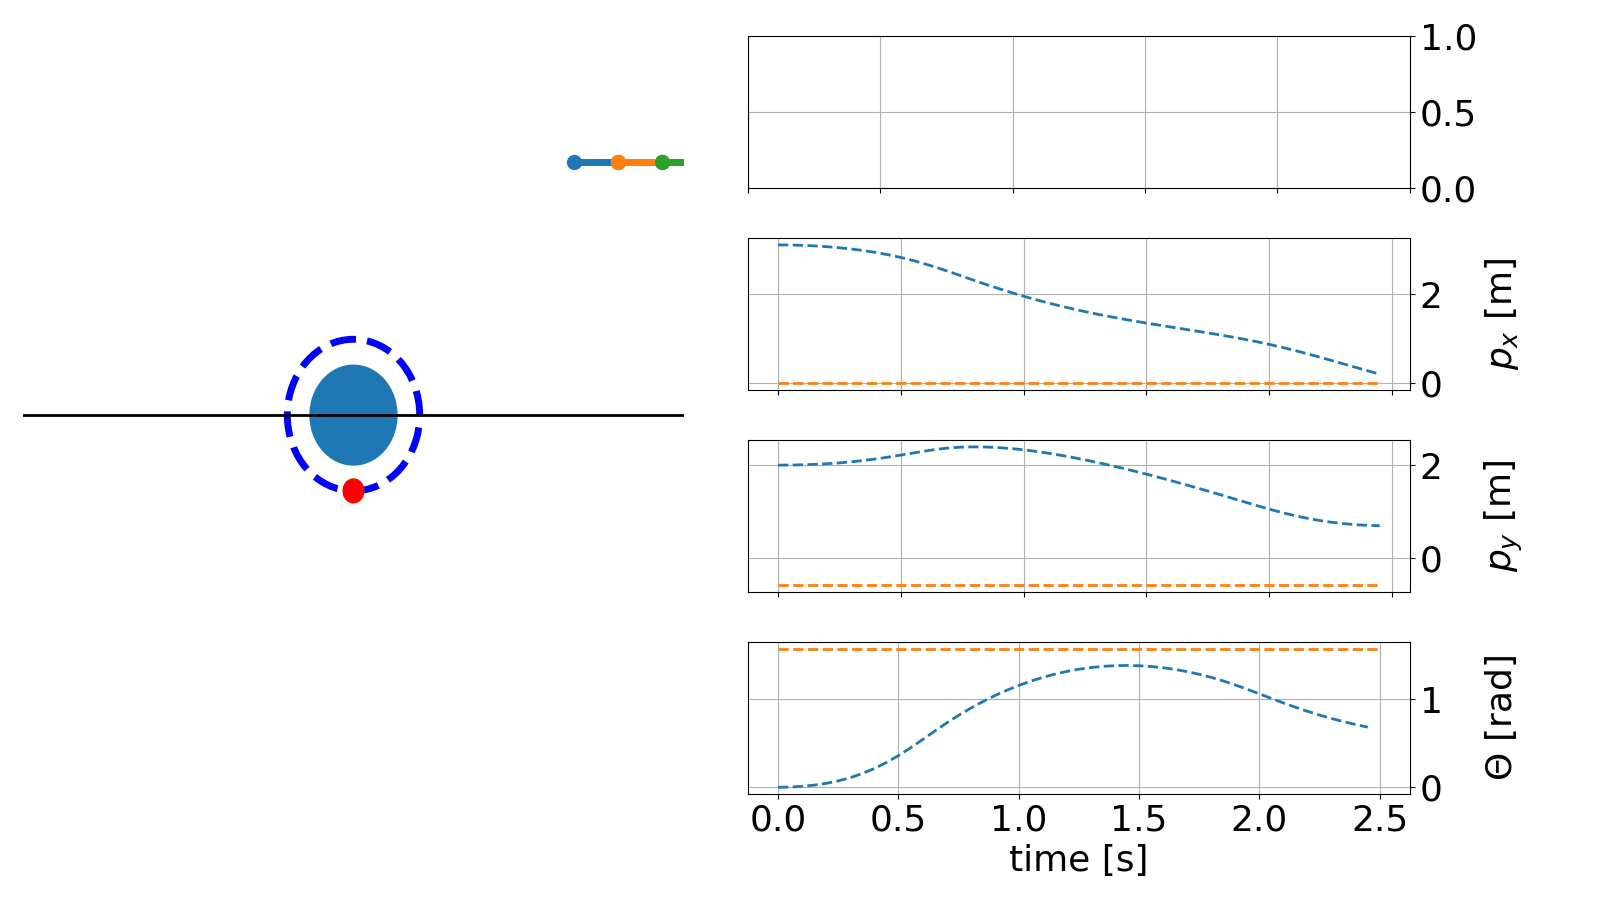

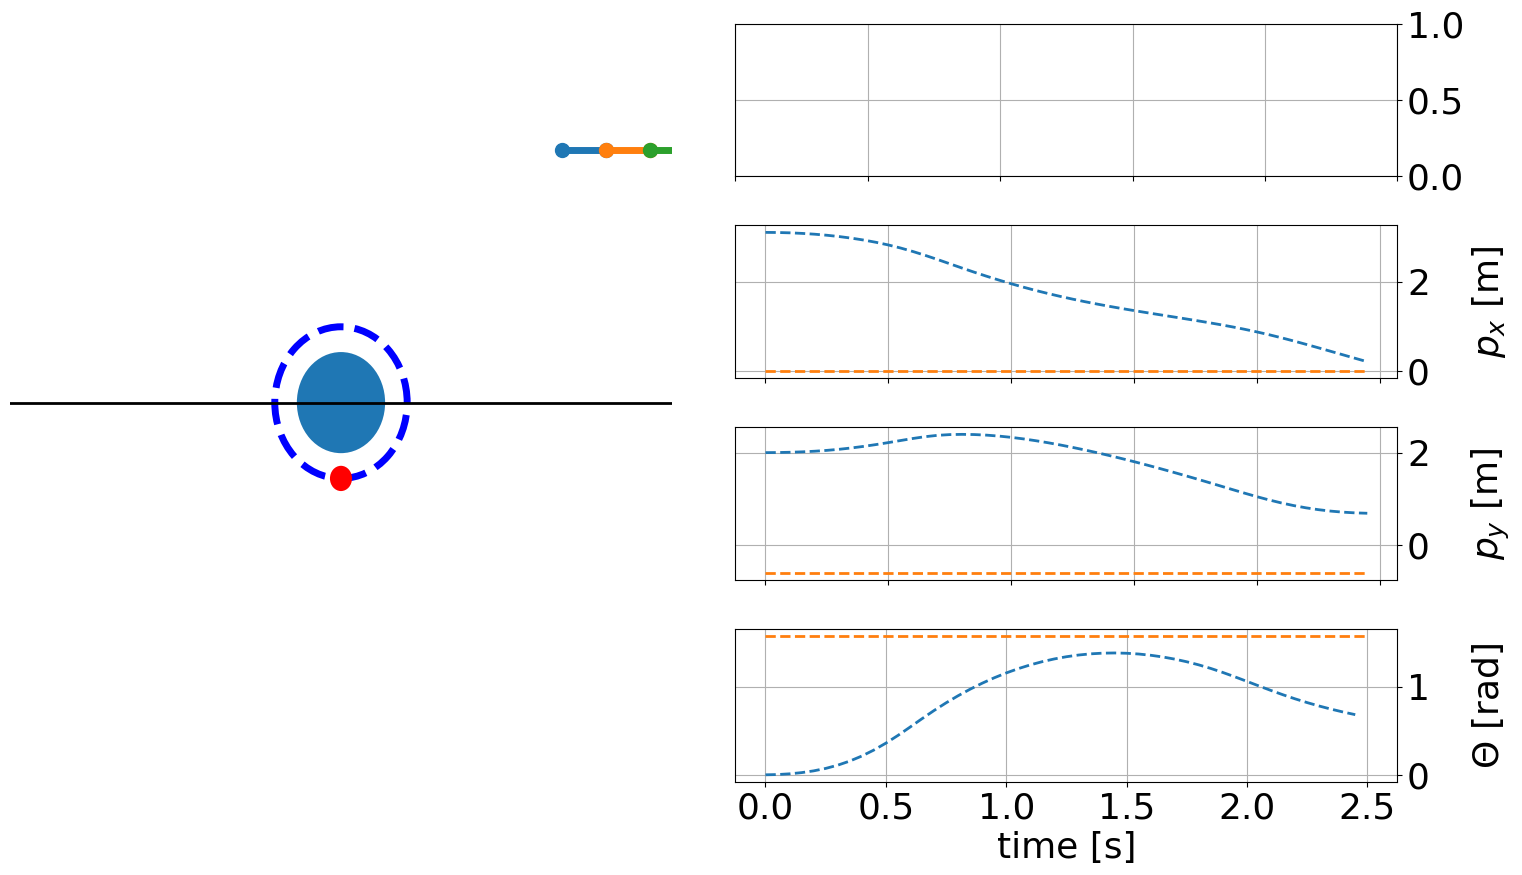

In [ ]:

#IMPORTATION DES BIBLIOTHEQUES

# Preparation du module graphique
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)

import matplotlib.pyplot as plt
plt.ion()
from matplotlib import rcParams
rcParams['text.usetex'] = False
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 2.0
rcParams['axes.labelsize'] = 'xx-large'
rcParams['xtick.labelsize'] = 'xx-large'
rcParams['ytick.labelsize'] = 'xx-large'
rcParams['font.size'] = 15

from matplotlib.patches import Circle

def robot(x):
    x = x.flatten()

    chassis_x = np.array([
        x[0],
        x[0] + l1*np.cos(x[2])
    ])
    chassis_y = np.array([
        x[1],
        x[1] + l1*np.sin(x[2])
    ])

    barre_intermediaire_x = np.array([
        chassis_x[1],
        chassis_x[1] + l2*np.cos(x[2]+x[3])
    ])
    barre_intermediaire_y = np.array([
        chassis_y[1],
        chassis_y[1] + l2*np.sin(x[2]+x[3])
    ])

    effecteur_x = np.array([
        barre_intermediaire_x[1],
        barre_intermediaire_x[1] + l3*np.cos(x[2]+x[3]+x[4])
    ])
    effecteur_y = np.array([
        barre_intermediaire_y[1],
        barre_intermediaire_y[1] + l3*np.sin(x[2]+x[3]+x[4])
    ])

    chassis = np.stack((chassis_x, chassis_y))
    barre_intermediaire = np.stack((barre_intermediaire_x, barre_intermediaire_y))
    effecteur = np.stack((effecteur_x, effecteur_y))

    return chassis, barre_intermediaire, effecteur


fig = plt.figure(figsize=(16,9))

ax1 = plt.subplot2grid((4, 2), (0, 0), rowspan=5)
ax2 = plt.subplot2grid((4, 2), (0, 1))
ax3 = plt.subplot2grid((4, 2), (1, 1))
ax4 = plt.subplot2grid((4, 2), (2, 1))
ax5 = plt.subplot2grid((4, 2), (3, 1))


ax3.set_ylabel('$p_{x}$ [m]')
ax4.set_ylabel('$p_{y}$ [m]')
ax5.set_ylabel('$\Theta$ [rad]')

# Axis on the right.
for ax in [ax2, ax3, ax4, ax5]:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    if ax != ax5:
        ax.xaxis.set_ticklabels([])

ax5.set_xlabel('time [s]')


mpc_graphics.add_line(var_type='_aux', var_name='p_x', axis=ax3)
mpc_graphics.add_line(var_type='_aux', var_name='p_x_set', axis=ax3)
mpc_graphics.add_line(var_type='_aux', var_name='p_y', axis=ax4)
mpc_graphics.add_line(var_type='_aux', var_name='p_y_set', axis=ax4)
mpc_graphics.add_line(var_type='_aux', var_name='theta', axis=ax5)
mpc_graphics.add_line(var_type='_tvp', var_name='theta_set', axis=ax5)

ax1.axhline(0,color='black')

bar1 = ax1.plot([],[], '-o', linewidth=5, markersize=10)
bar2 = ax1.plot([],[], '-o', linewidth=5, markersize=10)
bar3 = ax1.plot([],[], '-o', linewidth=5, markersize=10)

if 1 == 1:
    circle = Circle((obstacle['x'], obstacle['y']), obstacle['r'])
    ax1.add_artist(circle)
circle = Circle((cercle_bleu['x'], cercle_bleu['y']), cercle_bleu['r'], edgecolor='blue', fill=False, linestyle='--', linewidth=5)
ax1.add_artist(circle)
circle = Circle((-cercle_bleu['r']*np.cos(theta_obj), -cercle_bleu['r']*np.sin(theta_obj)), 0.1, facecolor='red', fill=True)
ax1.add_artist(circle)

size_ax = 3
ax1.set_xlim(-size_ax,size_ax)
ax1.set_ylim(-size_ax,size_ax)
ax1.set_axis_off()

fig.align_ylabels()
fig.tight_layout()

# INITIALISATION DU SIMULATEUR

simulator.x0['x1'] = 2
simulator.x0['x2'] = 2
simulator.x0['x3'] = 0
simulator.x0['x4'] = 0
simulator.x0['x5'] = 0
simulator.x0['v1'] = 0
simulator.x0['v2'] = 0
simulator.x0['v3'] = 0
simulator.x0['v4'] = 0

# Declaration de l'etat initial
x0 = simulator.x0.cat.full()
mpc.x0 = x0
estimator.x0 = x0
mpc.set_initial_guess()


# Test de l'affichage graphique
chassis, barre_intermediaire, effecteur = robot(x0)
bar1[0].set_data(chassis[0],chassis[1])
bar2[0].set_data(barre_intermediaire[0],barre_intermediaire[1])
bar3[0].set_data(effecteur[0],effecteur[1])

#mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()
fig


mpc.reset_history()

time_list = []
for k in range(N_sim):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)

from matplotlib.animation import PillowWriter, ImageMagickWriter

# The function describing the gif:
x_arr = mpc.data['_x']
def update(t_ind):
    chassis, barre_intermediaire, effecteur = robot(x_arr[t_ind])
    bar1[0].set_data(chassis[0],chassis[1])
    bar2[0].set_data(barre_intermediaire[0],barre_intermediaire[1])
    bar3[0].set_data(effecteur[0],effecteur[1])
    mpc_graphics.plot_results(t_ind)
    mpc_graphics.plot_predictions(t_ind)
    mpc_graphics.reset_axes()

anim = FuncAnimation(fig, update, frames=N_sim, repeat=False)
gif_writer = PillowWriter(fps=10)

# Save the animation to a file
anim.save('anim_robot.gif', writer=gif_writer) # Save the animation before displaying it.


from IPython.display import Image, display

display(Image('anim_robot.gif'))

VISUALISATION DES RESULTATS

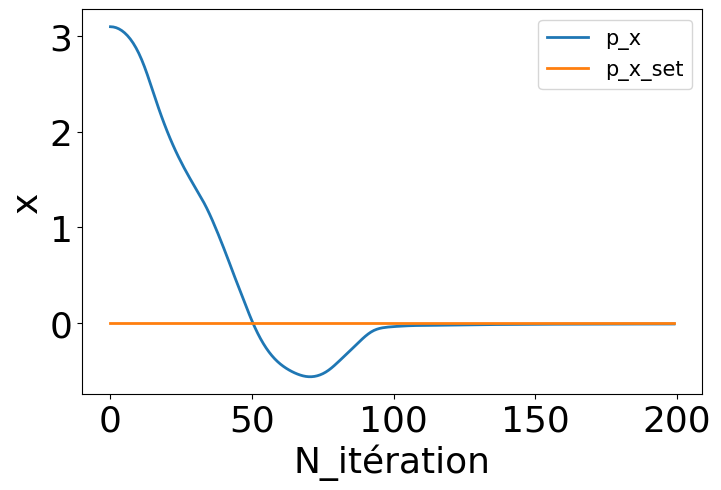

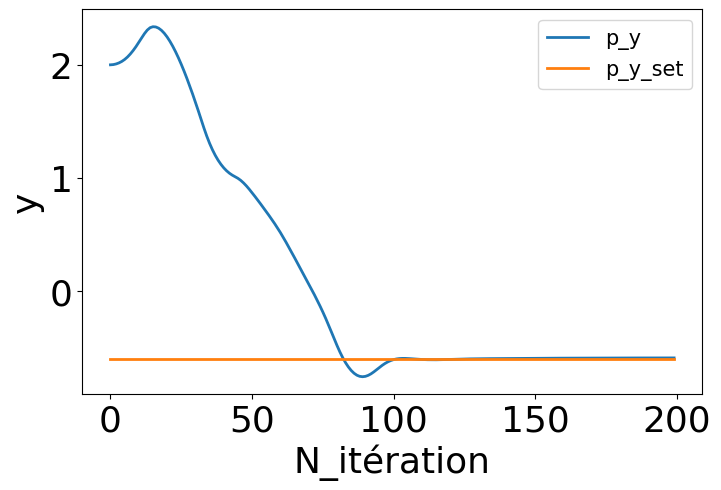

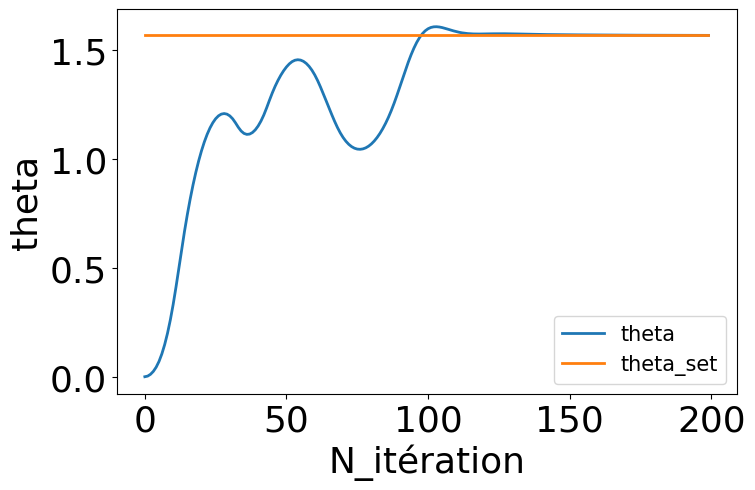

<Figure size 1000x1000 with 0 Axes>

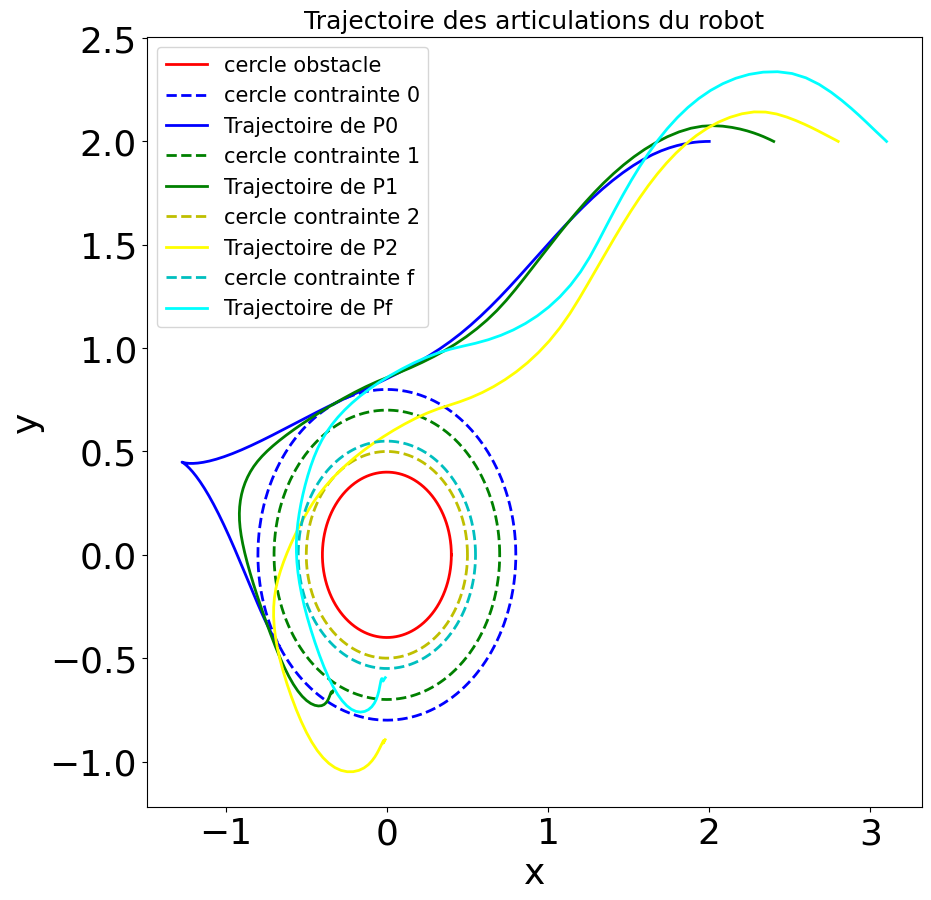

In [ ]:
values_p_x = mpc.data['_aux', 'p_x']
values_p_x_set = mpc.data['_aux', 'p_x_set']
values_p_y = mpc.data['_aux', 'p_y']
values_p_y_set = mpc.data['_aux', 'p_y_set']
values_theta = mpc.data['_aux', 'theta']
values_theta_set = mpc.data['_tvp', 'theta_set']

values_p0_x_var = mpc.data['_aux', 'p0_x_var']
values_p0_y_var = mpc.data['_aux', 'p0_y_var']
values_p1_x_var = mpc.data['_aux', 'p1_x_var']
values_p1_y_var = mpc.data['_aux', 'p1_y_var']
values_p2_x_var = mpc.data['_aux', 'p2_x_var']
values_p2_y_var = mpc.data['_aux', 'p2_y_var']


plt.figure(figsize=(8, 5))
plt.plot(values_p_x, label='p_x')
plt.plot(values_p_x_set, label='p_x_set')

plt.xlabel('N_itération')
plt.ylabel('x')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(values_p_y, label='p_y')
plt.plot(values_p_y_set, label='p_y_set')

plt.xlabel('N_itération')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(values_theta, label='theta')
plt.plot(values_theta_set, label='theta_set')

plt.xlabel('N_itération')
plt.ylabel('theta')
plt.legend()
plt.grid()
plt.show()

r_obs = 0.4
plt.figure(figsize = (10,10))
T = np.linspace(0,2*np.pi,1000)
X_obs,Y_obs = r_obs*np.cos(T),r_obs*np.sin(T)
X_0,Y_0 = d_secu0*np.cos(T),d_secu0*np.sin(T)
X_1,Y_1 = d_secu1*np.cos(T),d_secu1*np.sin(T)
X_2,Y_2 = d_secu2*np.cos(T),d_secu2*np.sin(T)
X_f,Y_f = d_secuf*np.cos(T),d_secuf*np.sin(T)

plt.figure(figsize = (10,10))
#Anti-collision 1

plt.plot(X_obs, Y_obs, label='cercle obstacle', color='red')
plt.plot(X_0, Y_0,'--b', label='cercle contrainte 0')
plt.plot(values_p0_x_var, values_p0_y_var, label='Trajectoire de P0', color='blue')
plt.xlabel('x')
plt.ylabel('y')

#Anti-collision 2


plt.plot(X_1, Y_1,'--g', label='cercle contrainte 1')
plt.plot(values_p1_x_var, values_p1_y_var, label='Trajectoire de P1', color='green')
plt.xlabel('x')
plt.ylabel('y')

#Anti-collision 3


plt.plot(X_2, Y_2,'--y', label='cercle contrainte 2')
plt.plot(values_p2_x_var, values_p2_y_var, label='Trajectoire de P2', color='yellow')
plt.xlabel('x')
plt.ylabel('y')

#Anti-collision 4

plt.title("Trajectoire des articulations du robot" )
plt.plot(X_f, Y_f,'--c', label='cercle contrainte f')
plt.plot(values_p_x, values_p_y, label='Trajectoire de Pf', color='cyan')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()